In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc2


## Loading

In [21]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "nhis_income_pca",
    "normalize": True,
  },
  "handle_imbalance": None,
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot",
    "froze_ms_coefs_round": 50
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 64,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0000,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new2": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4,
      "mm_thres": 200
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 300,
            "learning_rate": 0.001,
            "weight_decay": 0.0,
            "pred_round": 500,
            "pred_local_epochs": 3,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [23]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def vis_mm_sim(mm_coefs, metric = 'cos'):
    n_cols = 5
    n_rows = (mm_coefs.shape[0] - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(mm_coefs.shape[0]):
        
        X = mm_coefs[feature_idx]
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("Mechanism Similarity")
    plt.tight_layout()
    plt.show()

In [24]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'
dataset = 'codon'

# Subcase1 -  1 vs N Uneven Split LR

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirl1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [2341, 1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:24:01.019 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:24:01.019 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:24:40.039 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:24:40.039 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:25:19.204 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:25:19.204 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:25:23.694 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 84.30621059999976


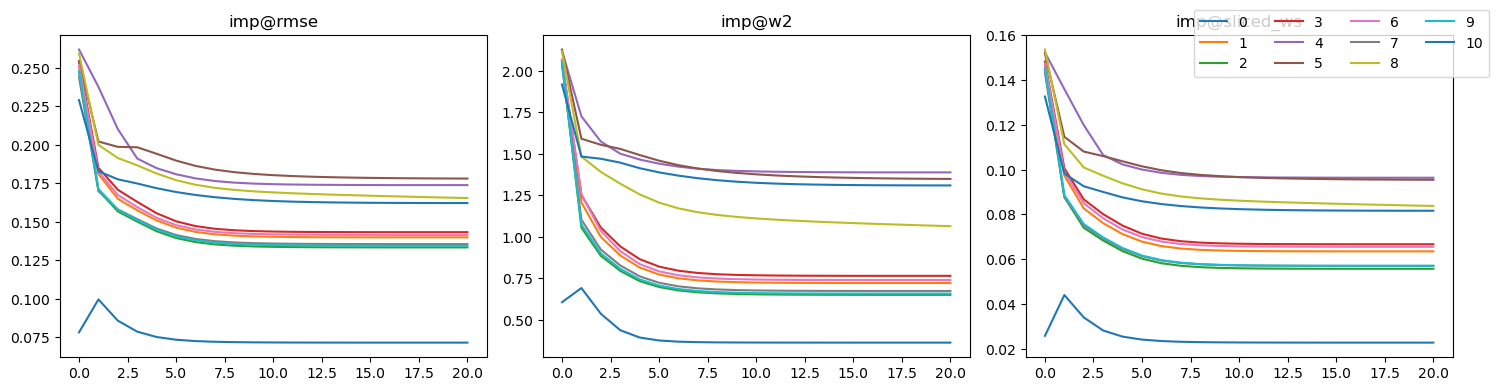

{'imp@rmse': 0.14369768965495705, 'imp@ws': 0.881302632471361, 'imp@sliced_ws': 0.06779987640813988}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirl1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [2341, 1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:25:30.140 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:25:30.140 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:26:05.794 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:26:05.794 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:26:45.053 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:26:45.054 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:26:48.978 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 80.46422699999675


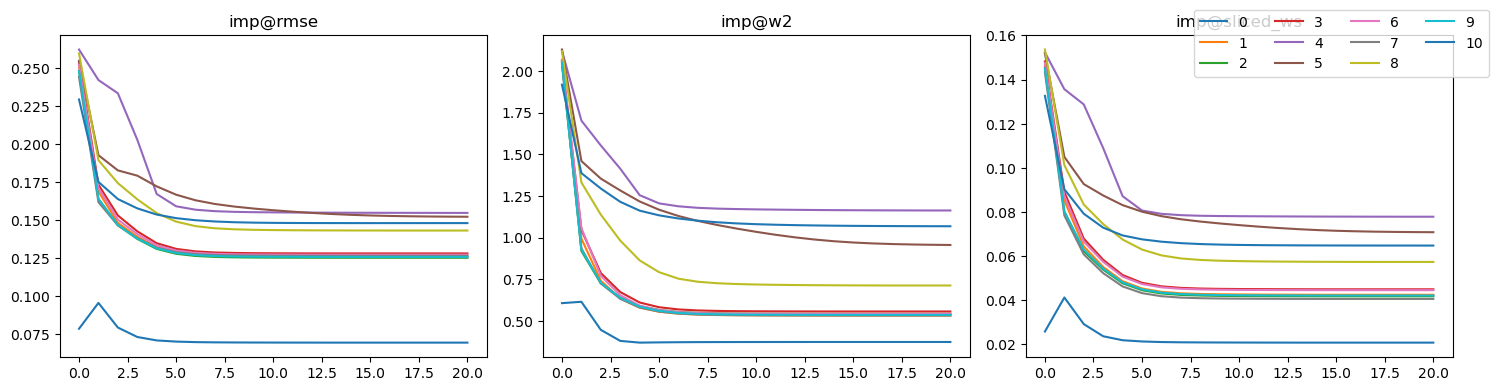

{'imp@rmse': 0.12943896045979167, 'imp@ws': 0.6832716619314415, 'imp@sliced_ws': 0.04978811580965244}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirl1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [2341, 1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:26:55.371 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:26:55.371 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:27:30.760 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:27:30.760 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:28:10.029 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:28:10.030 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:28:13.984 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 80.21498280000378


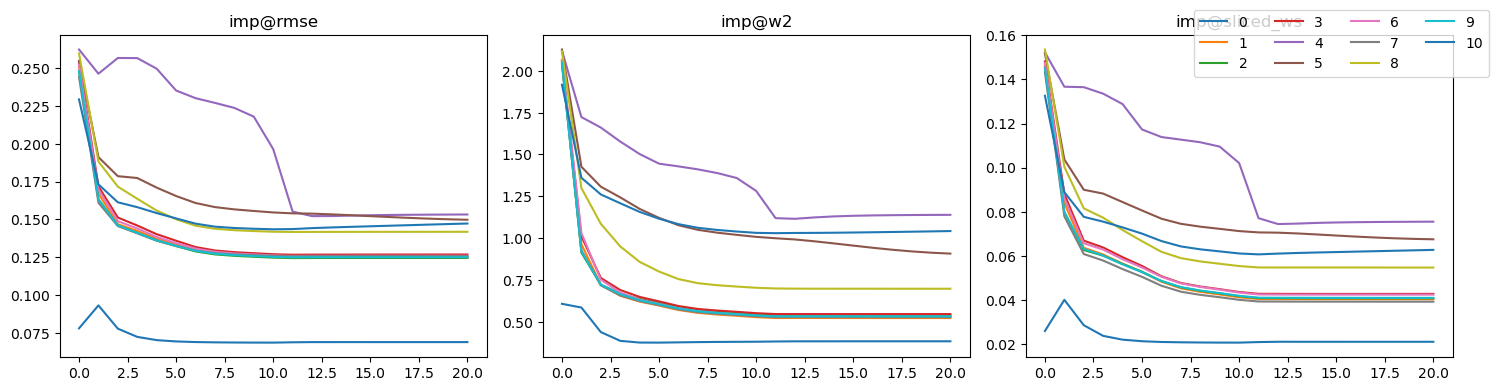

{'imp@rmse': 0.128674520810927, 'imp@ws': 0.6699961125784653, 'imp@sliced_ws': 0.047860018684061416}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirl1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [2341, 1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:28:20.406 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:28:20.407 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:28:55.640 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:28:55.641 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:29:34.536 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:29:34.537 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:29:38.400 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 79.61599859999842


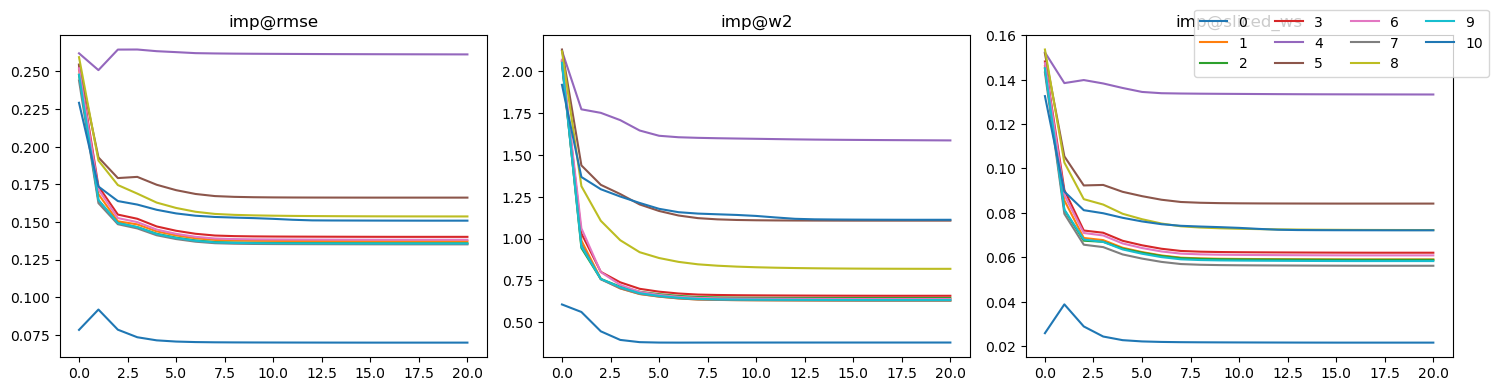

{'imp@rmse': 0.14760038027442396, 'imp@ws': 0.8033372296847869, 'imp@sliced_ws': 0.06713761870236154}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirl1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [2341, 1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:29:44.849 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:29:44.849 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:30:19.878 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:30:19.879 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:30:58.616 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:30:58.616 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:31:02.512 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 79.2723279999991


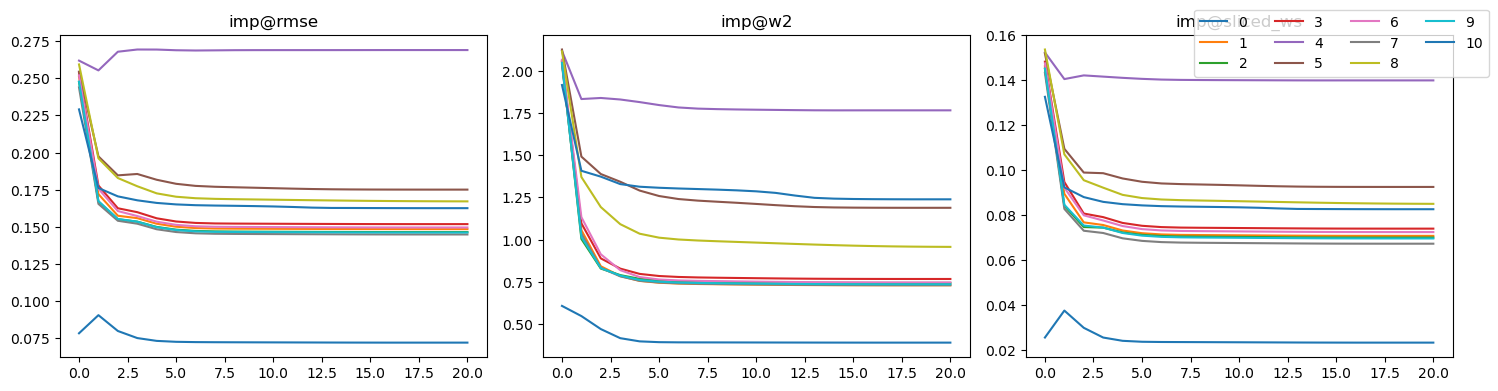

{'imp@rmse': 0.1575740202016268, 'imp@ws': 0.9082319569308669, 'imp@sliced_ws': 0.07716404651878482}


In [25]:
results_compl_alpha = []

for alpha in [0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 11
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'sample-unevendirl1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

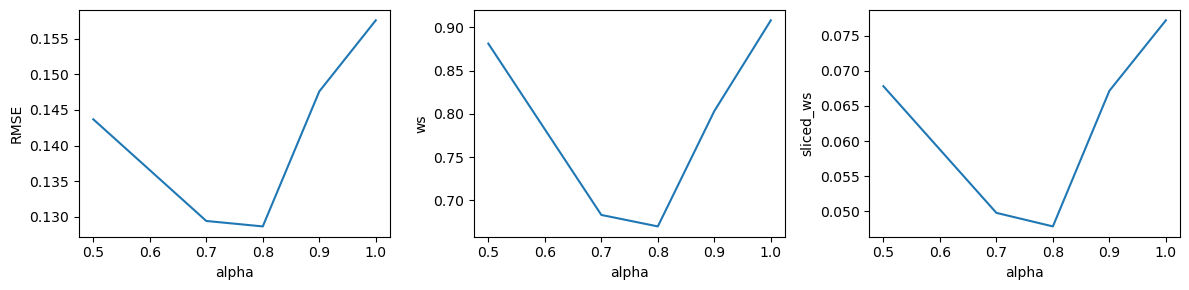

In [26]:
x = [0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.17884472919516609
# ws =  0.4496532470292862
# sliced_ws = 0.09188334255186284
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# Subcase 2 - 1 vs N Uevenly Split RL

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirr1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57, 2341]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:31:09.191 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:31:09.192 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:31:45.706 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:31:45.706 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:32:25.950 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:32:25.950 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:32:30.041 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 82.47092589999374


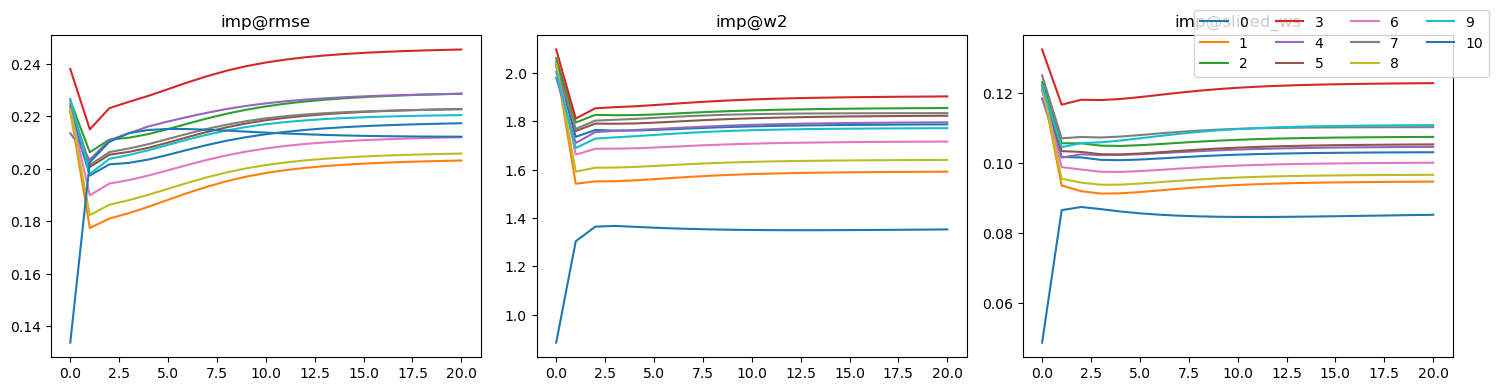

{'imp@rmse': 0.21961163304807904, 'imp@ws': 1.7322396055224187, 'imp@sliced_ws': 0.10373622994009718}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirr1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57, 2341]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:32:36.429 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:32:36.430 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:33:13.247 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:33:13.248 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:33:53.393 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:33:53.394 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:33:57.455 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 82.63649669999722


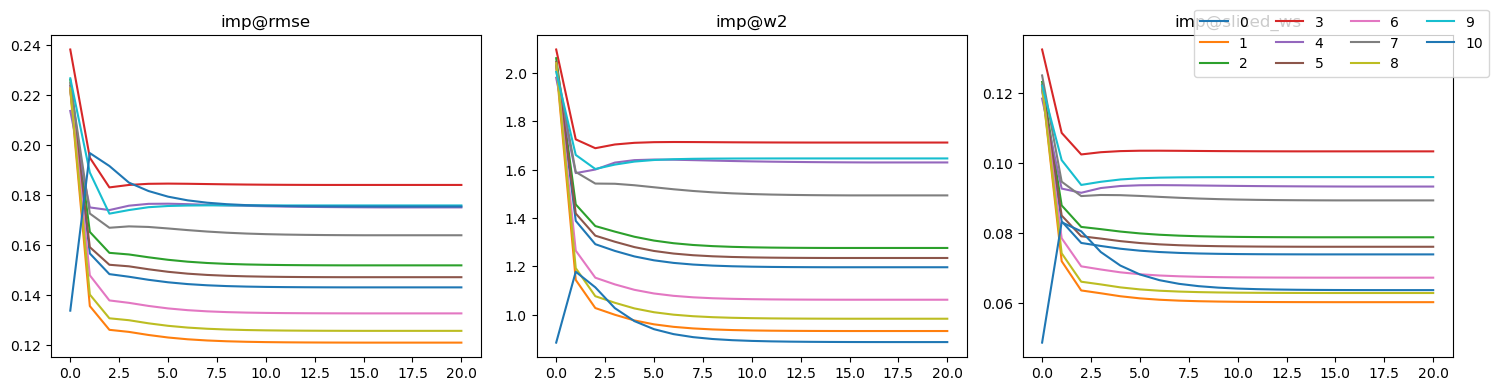

{'imp@rmse': 0.15409829992662658, 'imp@ws': 1.2775928909229317, 'imp@sliced_ws': 0.07864110107880752}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirr1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57, 2341]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:34:03.860 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:34:03.860 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:34:40.216 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:34:40.217 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:35:20.454 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:35:20.455 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:35:24.511 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 82.2801840999964


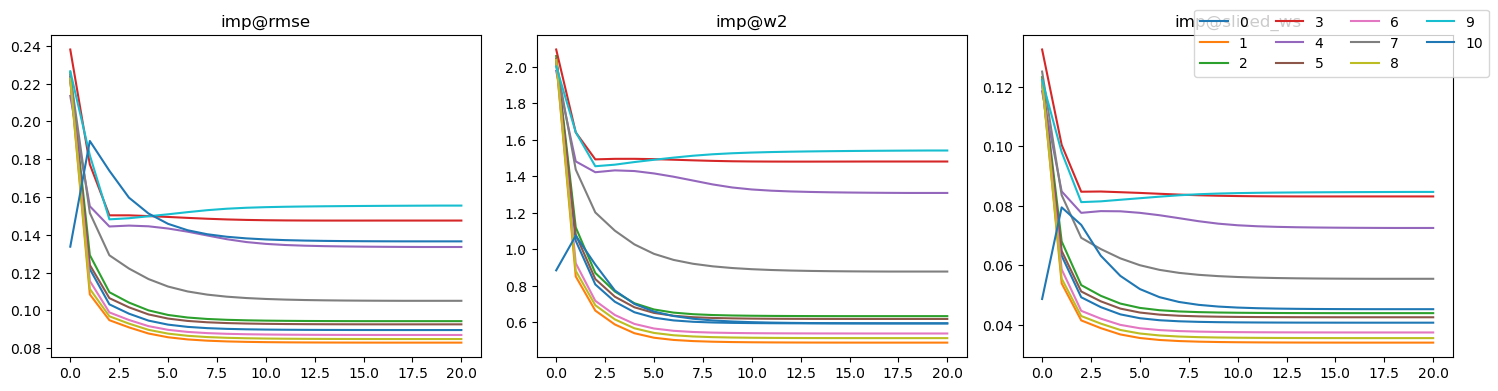

{'imp@rmse': 0.10995997848373484, 'imp@ws': 0.8357146588665209, 'imp@sliced_ws': 0.052275214235783275}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirr1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57, 2341]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:35:30.964 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:35:30.964 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:36:07.251 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:36:07.251 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:36:47.465 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:36:47.466 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:36:51.459 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 82.12187769999582


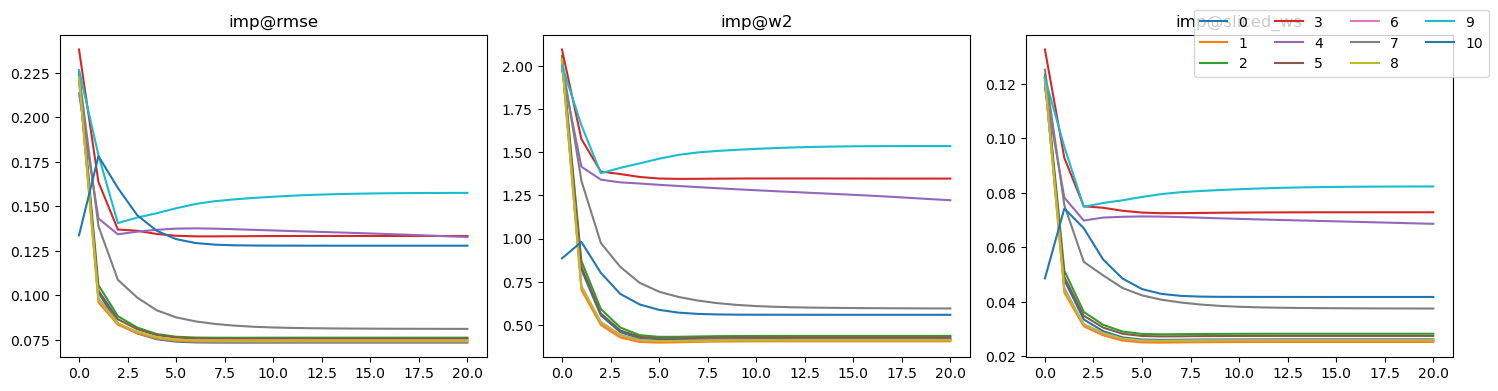

{'imp@rmse': 0.09840130776957104, 'imp@ws': 0.7071017955454222, 'imp@sliced_ws': 0.042097194287864764}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirr1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57, 2341]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:36:57.955 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:36:57.956 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:37:34.272 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:37:34.273 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:38:14.303 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:38:14.304 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:38:18.336 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 82.01456780000444


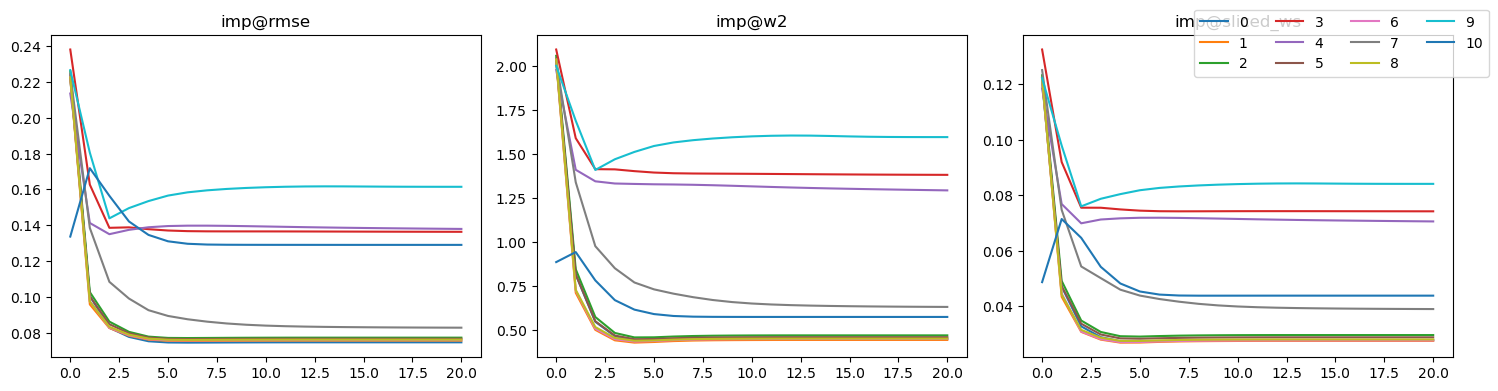

{'imp@rmse': 0.10045858221466733, 'imp@ws': 0.7447991149719034, 'imp@sliced_ws': 0.04372688278170969}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirr1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57, 2341]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:38:24.757 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:38:24.758 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:39:01.072 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:39:01.072 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:39:41.093 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:39:41.094 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:39:45.113 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 81.96730899999966


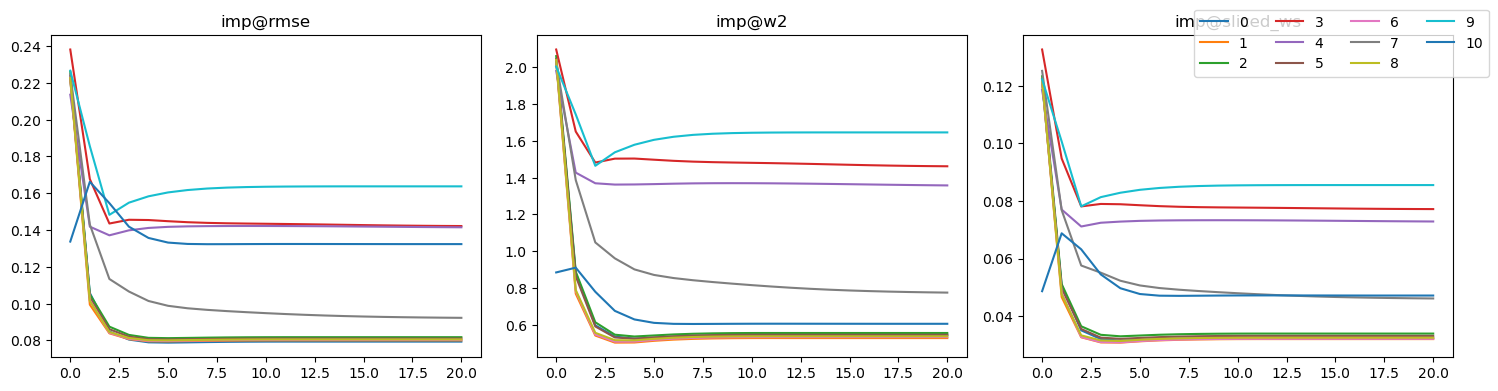

{'imp@rmse': 0.10507066120533583, 'imp@ws': 0.8275251213726716, 'imp@sliced_ws': 0.04775883384358976}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevendirr1 {}
537846 [1056.71400196 2266.6406794   674.55585304   59.48058596   63.83576478
  888.90989    1961.6411183   153.11294712 2184.27494812   56.83421132]
sample sizes:  [1057, 2267, 675, 60, 64, 889, 1962, 154, 2185, 57, 2341]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:39:51.603 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:39:51.603 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:40:28.578 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:40:28.579 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:41:09.704 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:41:09.705 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:41:13.780 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 83.84416269999929


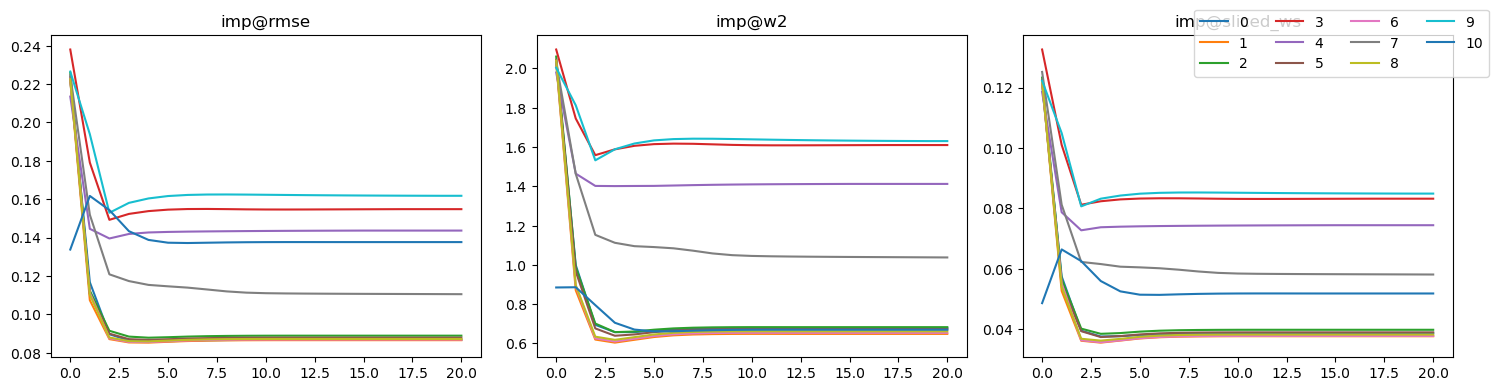

{'imp@rmse': 0.11199187330160569, 'imp@ws': 0.9417707768657596, 'imp@sliced_ws': 0.05308528167625835}


In [27]:
results_compl_alpha = []

for alpha in [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 11
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
    config2['data_partition']['strategy'] = 'sample-unevendirr1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

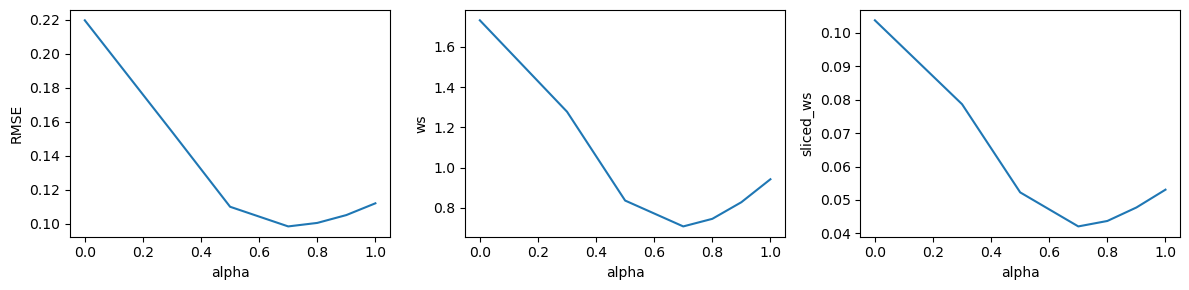

In [28]:
x = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.17884472919516609
# ws =  0.4496532470292862
# sliced_ws = 0.09188334255186284
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# Subcase2 - 2 clusters

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 1170, 302, 411, 1084, 2444, 1612]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:41:16.181 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:41:16.182 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:41:51.105 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:41:51.106 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:42:29.931 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:42:29.932 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:42:33.778 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 79.239476499999


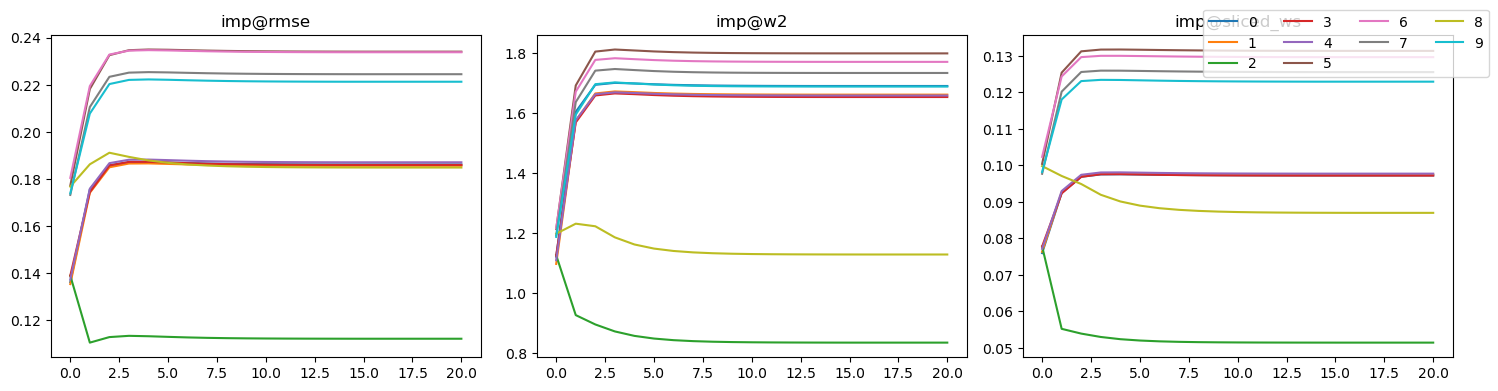

{'imp@rmse': 0.19553445273471695, 'imp@ws': 1.5611553165095469, 'imp@sliced_ws': 0.10375607371730364}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 1170, 302, 411, 1084, 2444, 1612]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:42:35.899 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:42:35.900 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:43:10.502 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:43:10.503 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:43:49.294 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:43:49.295 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:43:53.169 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 78.84661819999747


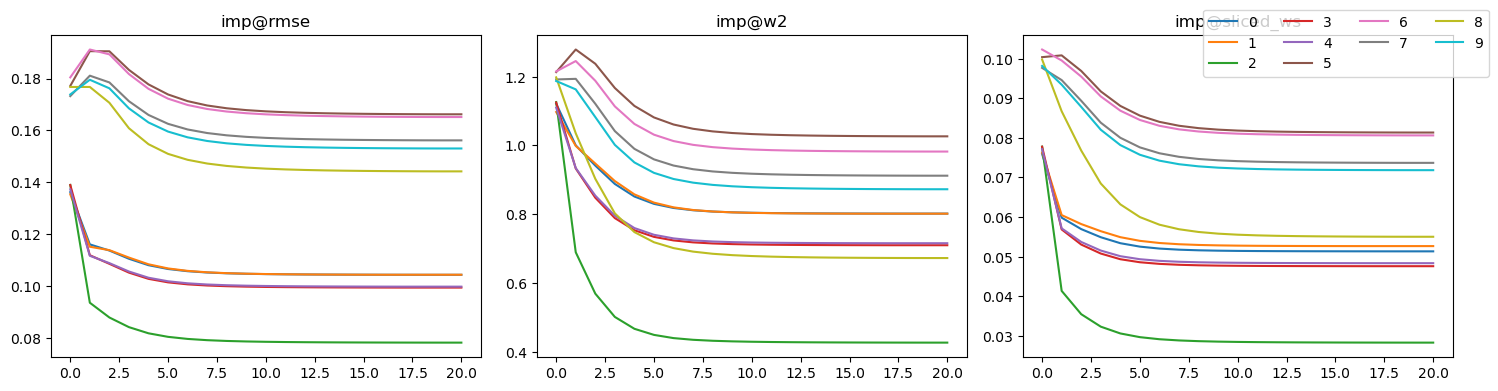

{'imp@rmse': 0.1271399626006963, 'imp@ws': 0.792463199446649, 'imp@sliced_ws': 0.05907940246109869}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 1170, 302, 411, 1084, 2444, 1612]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:43:55.277 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:43:55.278 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:44:30.167 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:44:30.168 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:45:08.603 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:45:08.604 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:45:12.433 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 78.73209010000573


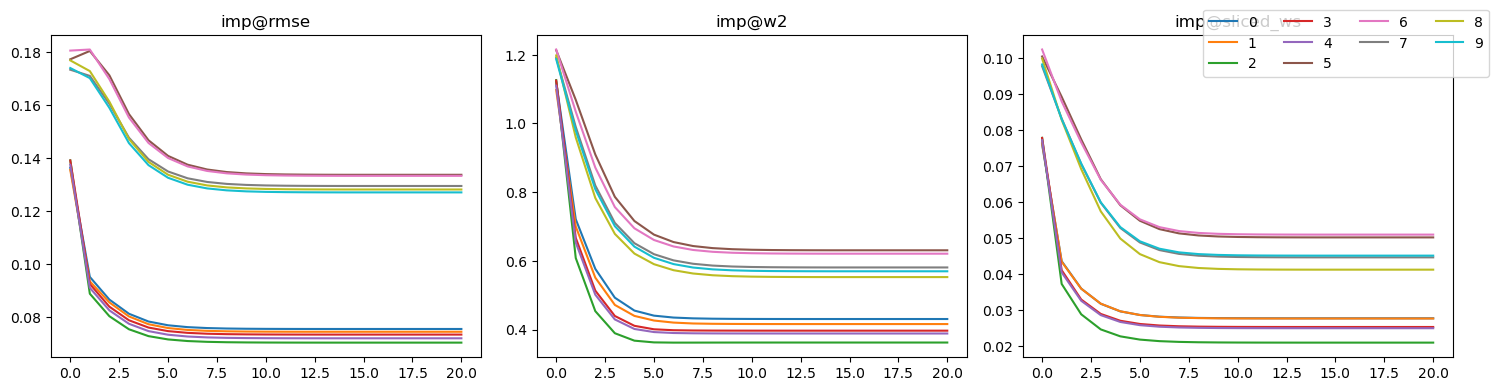

{'imp@rmse': 0.10159958353573804, 'imp@ws': 0.49486340553733865, 'imp@sliced_ws': 0.03584285427936066}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 1170, 302, 411, 1084, 2444, 1612]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:45:14.531 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:45:14.532 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:45:49.298 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:45:49.298 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:46:27.513 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:46:27.514 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:46:31.349 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 78.39265049999813


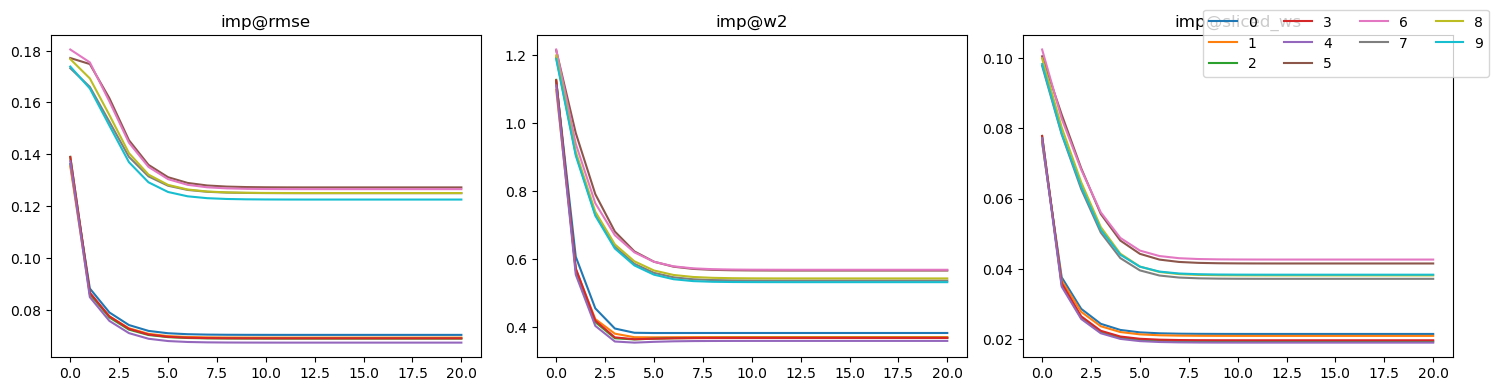

{'imp@rmse': 0.09710704035822058, 'imp@ws': 0.46038055988178067, 'imp@sliced_ws': 0.029880883486657347}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 1170, 302, 411, 1084, 2444, 1612]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:46:33.451 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:46:33.452 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:47:08.386 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:47:08.387 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:47:46.701 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:47:46.702 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:47:50.569 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 78.70187949999672


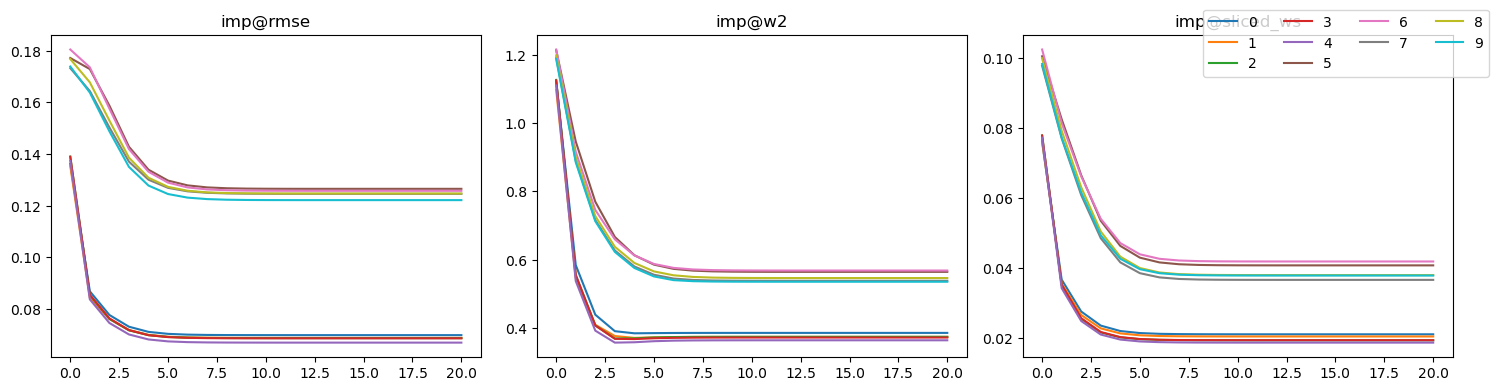

{'imp@rmse': 0.09671993758518983, 'imp@ws': 0.46205434787248173, 'imp@sliced_ws': 0.029325296088984276}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 1170, 302, 411, 1084, 2444, 1612]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:47:52.671 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:47:52.671 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:48:27.373 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:48:27.374 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:49:05.576 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:49:05.577 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:49:09.460 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 78.36127570000099


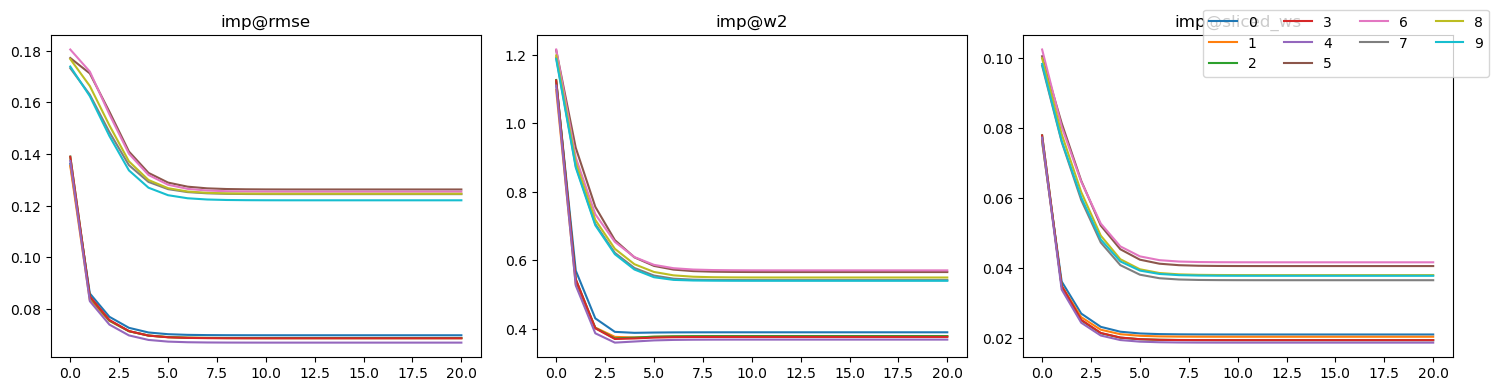

{'imp@rmse': 0.09663960066997815, 'imp@ws': 0.46559137862934996, 'imp@sliced_ws': 0.02920000504680633}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 1170, 302, 411, 1084, 2444, 1612]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-07 02:49:11.581 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:49:11.582 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-07 02:49:47.546 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:49:47.546 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-07 02:50:26.092 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-07 02:50:26.093 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-07 02:50:29.920 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 79.94124239999655


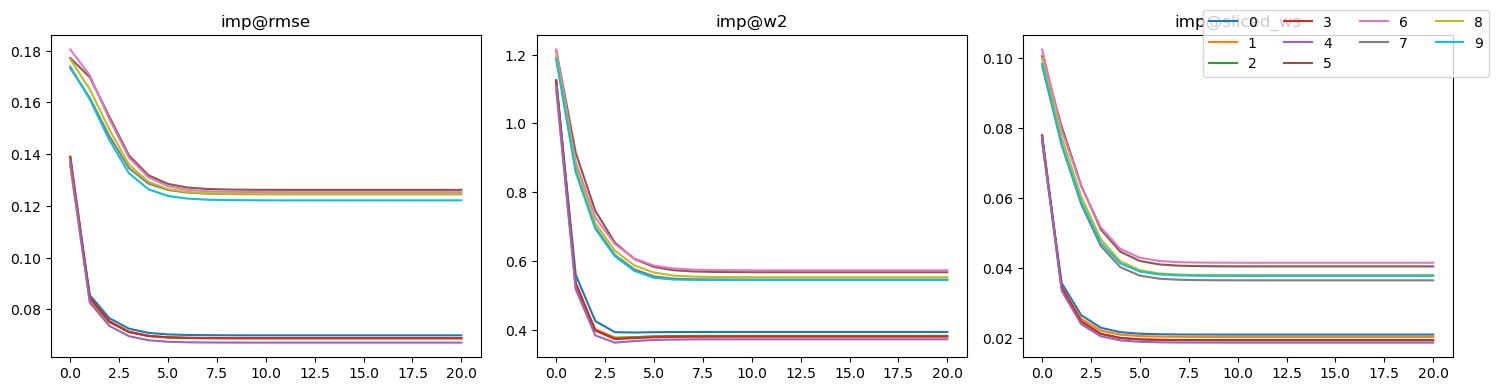

{'imp@rmse': 0.09664763021769933, 'imp@ws': 0.469143076171367, 'imp@sliced_ws': 0.02918336952104475}


In [29]:
results_compl_alpha = []
for alpha in [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
    config2['data_partition']['strategy'] = 'sample-uneven10'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

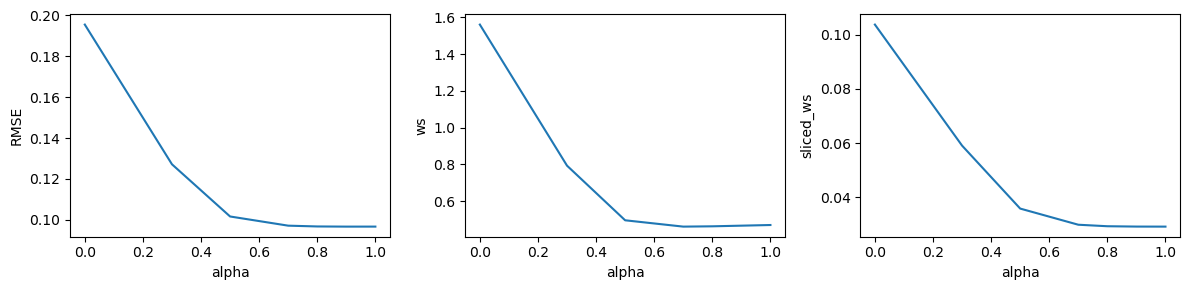

In [30]:
x = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.31724148632788224
# ws = 1.0327202461435718
# sliced_ws = 0.1650482253637849
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# end